*** Our goal is to accurately predict customer churn***

[WSDM KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge)

## The Business Problem

KKBox is the leader in music streaming in Asia and their business model is based on paid user accounts and advertising revenue with the former being a significant contributor. The client (KKBox) wants a predictive model of customer churn built.

Stage 1 requires descriptive analytics. We will present assumptions about the data & the intended model as we preprocess and explore...

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re

In [2]:
# As the name implies, this csv holds subscriber information

members = pd.read_csv('members_v2.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
1,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NaN,7,20110918
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,4,28,female,9,20110920


In [3]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null int64
gender                    318249 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: int64(4), object(2)
memory usage: 36.4+ MB


**Null values in the "gender" variable.**

In [4]:
members['gender'].describe()

count     318249
unique         2
top         male
freq      168385
Name: gender, dtype: object

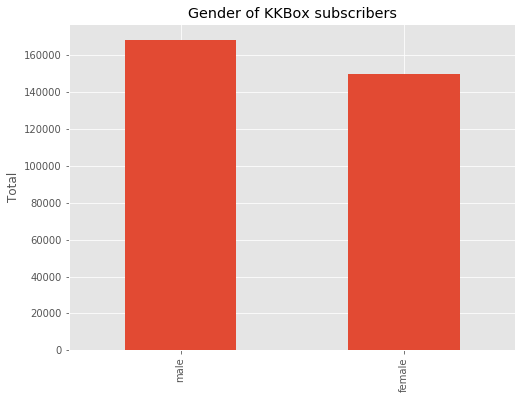

In [5]:
gender = members['gender'].value_counts()
gender.plot(kind='bar',stacked=True, figsize=(8,6))

plt.ylabel('Total')
plt.title("Gender of KKBox subscribers")
plt.show()

In [7]:
# Creating a 'missing' category/level for the gender variable

members['gender'] = members['gender'].fillna('missing')

# Investigating the age variable...

print members['bd'].max()
members['bd'].min()

2016


-3152

**The bd column is a placeholder for subscriber age whose entries range from -3152 to 2016**

*What assumptions can we make about this variable?*

- It is possible this field is stored in a Unix-like database that holds dates as either positive or negative offsets of 1970
- The values could also be user entry errors

As KKBox only accepts registrants from within Asia, we had someone from Hong Kong sign up and send us screenshots of the DOB data entry:

<table><tr><td><img src="correct.jpg" style="width: 250px;"></td><td><img src="wrong1.jpg" style="width: 250px;"></td><td><img src="wrong2.jpg" style="width: 250px;"></td></tr></table>

## Clearly, KKbox has data validation issues they need to attend to...

Our observations clearly rule out the Unix case... 

*** The number of subscribers of age 0 is staggering ***

In [8]:
print float(len(members['bd'][members['bd'] == 0]))*100/len(members['bd']),'% of subscribers in dataset are age 0'

60.4345420015 % of subscribers in dataset are age 0


** We will assume there are no supercentenarians beyond 120 years of age and mark such occurrences as invalid. **

[Link here](https://en.wikipedia.org/wiki/List_of_supercentenarians_from_Asia)

** We will also assume children aged 1 - 10 have been signed up by their parents. We do not expect this assumption to affect our model significantly especially since there are so few of them. **

In [9]:
members.loc[members['bd'] < 0, 'bd'] = np.nan
members.loc[members['bd'] > 120, 'bd'] = np.nan

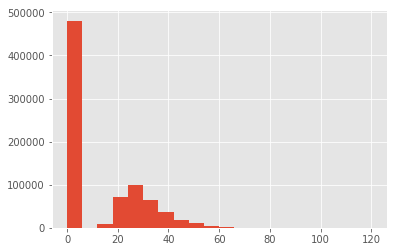

In [10]:
members['bd'].hist(bins=20)
plt.show()

In [11]:
median = members['bd'][members['bd'] > 0].median()
members['bd'] = members['bd'].fillna(median)

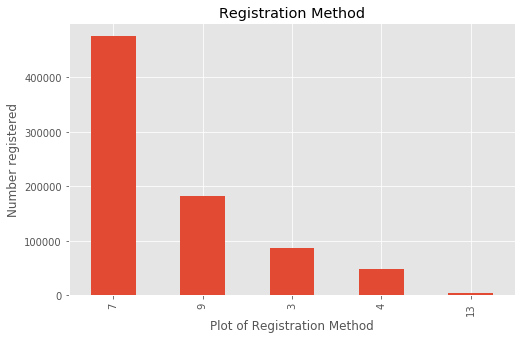

In [12]:
registered_via = members['registered_via'].value_counts()
registered_via.plot(kind='bar',stacked=True, figsize=(8,5))

plt.xlabel('Plot of Registration Method')
plt.ylabel('Number registered')
plt.title("Registration Method")
plt.show()

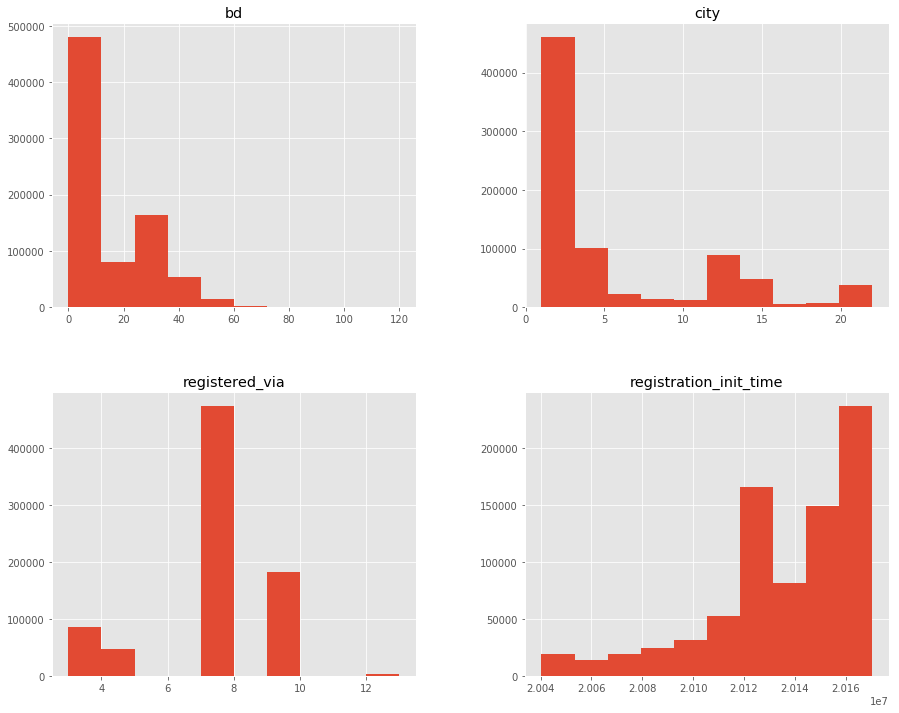

In [13]:
members.hist(figsize=(15,12))
plt.show()

In [15]:
train = pd.read_csv("train_v2.csv")

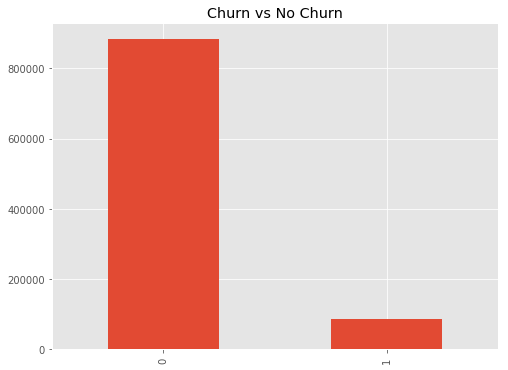

In [16]:
churn = train['is_churn'].value_counts()
churn.plot(kind='bar',stacked=True, figsize=(8,6))

plt.title("Churn vs No Churn")
plt.show()

** We're running our predictive model on data that we've further pre-processed with Alteryx Designer **

Workflow-1: Extracting Member Information for the train IDs

<img src="train_members.JPG">

Workflow-2: Extracting Transactions Information for the train IDs

<img src="train_transactions.JPG">

Workflow-3: Creating new variables from the transactions data

<img src="train_New_Variables.JPG">

Workflow-4: Extracting information on from user logs data using the train IDs

<img src="train_userlogs.JPG">

Workflow-6: Creating new variables from the userlogs & train combined data

<img src="train_userlogs_info.JPG">

The train dataset was created using the above workflows in Alteryx. Similar workflows were created to build the test dataset.

We will run Random Forest Classifier on our combined dataset to identify the most important features and disregard age if it is not an important feature.

In [17]:
data1 = pd.read_csv('finaltrain_V2.csv')
data2 = pd.read_csv('finaltest_V2.csv')

In [18]:
print data1.shape
print data2.shape

(970960, 147)
(907471, 141)


#### From investigation, the additional variables in train data not in test data are:
  list_price_105  
  list_price_126  
  list_price_210  
  plan_days_3  
  plan_days_21  
  list_price_1299  
  list_price_1399 
  
 #### The additional variables in test data not in train data are:
 city_21

In [19]:
# completing dataframes so train and test have the same columns

# test dataframe
data2['list_price_105'] = 0
data2['list_price_126'] = 0
data2['list_price_210'] = 0
data2['plan_days_3'] = 0
data2['plan_days_21'] = 0
data2['list_price_1299'] = 0
data2['list_price_1399'] = 0
# train dataframe
data1['city_21'] = 0

In [20]:
print data1.shape
print data2.shape

(970960, 148)
(907471, 148)


In [21]:
# creating a function to snakify column names
def snakify(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# snakifying column names in both train and test
data1.columns = [snakify(col) for col in data1.columns]
data2.columns = [snakify(col) for col in data2.columns]

# creatiung a list of column names that are def. not dummy variables
subset = list(data1.columns[:17])
type(subset)

list

In [22]:
# looking for the columns that hold null values in both train and hold-out dataset
print data1.columns[data1.isnull().any()]
print data2.columns[data1.isnull().any()]

Index([u'sum_num_unq', u'avg_num_unq', u'sum_total_number_songs',
       u'avg_total_number_songs', u'sum_total_secs', u'avg_total_secs',
       u'avg_total_score', u'bd', u'registered_via', u'registration_init_time',
       u'registration_init_days', u'total_amount_paid', u'is_auto_renew'],
      dtype='object')
Index([u'sum_num_unq', u'avg_num_unq', u'sum_total_number_songs',
       u'avg_total_number_songs', u'sum_total_secs', u'avg_total_secs',
       u'avg_total_score', u'bd', u'registered_via', u'registration_init_time',
       u'registration_init_days', u'total_amount_paid', u'is_auto_renew'],
      dtype='object')


In [23]:
# inspecting datatypes in our subset
data1[subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 17 columns):
msno                      970960 non-null object
sum_num_unq               754551 non-null float64
avg_num_unq               754551 non-null float64
sum_total_number_songs    754551 non-null float64
avg_total_number_songs    754551 non-null float64
sum_total_secs            754551 non-null float64
avg_total_secs            754551 non-null float64
avg_total_score           754551 non-null float64
bd                        699492 non-null float64
registered_via            699492 non-null float64
registration_init_time    699492 non-null object
registration_init_days    699492 non-null object
no_of_transactions        970960 non-null int64
no_of_cancellations       970960 non-null int64
cancelled                 970960 non-null int64
total_amount_paid         933578 non-null float64
is_auto_renew             933578 non-null float64
dtypes: float64(11), int64(3), object(3)
memory 

In [24]:
# converting the registration date variable from object to float
data1['registration_init_days'] = data1['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)
data2['registration_init_days'] = data2['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)

# subsetting categorical and continuous variables so we can transform with ease
cat = ['registered_via', 'is_auto_renew']
intgr = ['sum_num_unq', 'avg_num_unq', 'sum_total_number_songs', 'avg_total_number_songs', 'sum_total_secs', 'avg_total_secs',
        'avg_total_score', 'bd', 'registration_init_days', 'total_amount_paid']

# how many nulls exist in each of our subsets?
data1[subset].isnull().sum()

msno                           0
sum_num_unq               216409
avg_num_unq               216409
sum_total_number_songs    216409
avg_total_number_songs    216409
sum_total_secs            216409
avg_total_secs            216409
avg_total_score           216409
bd                        271468
registered_via            271468
registration_init_time    271468
registration_init_days    271468
no_of_transactions             0
no_of_cancellations            0
cancelled                      0
total_amount_paid          37382
is_auto_renew              37382
dtype: int64

In [25]:
# from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import Imputer

# we have registration_init_days as a continuous variable so _init_time is excluded
data1 = data1.drop(['registration_init_time'], axis=1)
data2 = data2.drop(['registration_init_time'], axis=1)

# imputing median values to nulls of continuous variables and mode to categoricals
imp_int = Imputer(strategy='median')
imp_cat = Imputer(strategy='most_frequent')

data1[intgr] = imp_int.fit_transform(data1[intgr])
data1[cat] = imp_cat.fit_transform(data1[cat])

data1.head(10)

,msno,sum_num_unq,avg_num_unq,sum_total_number_songs,avg_total_number_songs,sum_total_secs,avg_total_secs,avg_total_score,bd,registered_via,...,city_16,city_17,city_18,city_19,city_20,city_22,is_female,is_male,is_missing,city_21
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,885.0,28.548387,1089.0,35.129032,192527.891052,6210.577131,46.353226,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,468.0,16.714286,567.0,20.250000,115411.258972,4121.830678,35.864643,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,828.0,39.428571,970.0,46.190476,149896.558472,7137.931356,51.978095,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,230.0,7.931034,682.0,23.517241,116433.246857,4014.939547,36.092069,21.0,7.0,...,0,0,1,0,0,0,0,1,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,223.0,10.619048,233.0,11.095238,36636.637947,1744.601807,13.830476,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,39.0,19.500000,55.0,27.500000,10243.064697,5121.532349,43.285000,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,115.0,14.375000,157.0,19.625000,28450.267548,3556.283443,28.923750,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,163.0,18.111111,171.0,19.000000,31788.296082,3532.032898,27.855556,28.0,9.0,...,0,0,0,0,0,0,0,0,1,0
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,186.0,13.285714,319.0,22.785714,65936.727478,4709.766248,39.546429,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
9,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,25.0,9.0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
# imputing nulls in test dataset with measures of centrality from train to ensure our final predictions will be accurate
data2[intgr] = imp_int.transform(data2[intgr])
data2[cat] = imp_cat.transform(data2[cat])

# Investigating the distribution of churn levels
data1['is_churn'].value_counts()

0    883630
1     87330
Name: is_churn, dtype: int64

In [27]:
X, y = data1.drop(['is_churn', 'msno'], axis=1), data1['is_churn']

# ensuring we create an even split of the dependent variable (churn)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=13)
for train_index, test_index in sss.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    # reserving some train data to test our random forest best estimator prior to feeding new data
    X_test, y_test = X.loc[test_index], y.loc[test_index]

In [30]:
# searching an empirically selected grid of trees
rfgrid_test = [{'n_estimators':range(100,250,50)}]

rf_test = RandomForestClassifier(warm_start=True, criterion='gini',random_state=13)
gridsearch_test = GridSearchCV(rf_test, rfgrid_test, cv=8)
gridsearch_test.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 150, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
gridsearch_test.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True)

In [33]:
# refining the grid search to make intended model more accurate.
rf_grid = [{'n_estimators':range(150,210,10)}]

rf = RandomForestClassifier(warm_start=True, random_state=13, criterion='gini')
gridsearchRF = GridSearchCV(rf, rf_grid, cv=8)
gridsearchRF.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [150, 160, 170, 180, 190, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
# Printing parameters of the best estimator
gridsearchRF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True)

** Using 170 trees in the forest provide the best results **

In [35]:
# assigning best estimator to a variable
rf_best = gridsearchRF.best_estimator_

# viewing feature importance
for score, feature in sorted(zip(rf_best.feature_importances_,data1.columns),reverse=True):
    print(score, feature)

(0.21201307356463309, 'plan_days_7')
(0.1017504633168784, 'cancelled')
(0.062750544981417064, 'no_of_transactions')
(0.054171016967136956, 'no_of_cancellations')
(0.044791957406747504, 'registered_via')
(0.039009141171181982, 'registration_init_days')
(0.037048966916647483, 'avg_total_number_songs')
(0.035267160996703711, 'avg_num_unq')
(0.035092319087819408, 'msno')
(0.033623101546791302, 'sum_total_secs')
(0.033514116315666947, 'avg_total_secs')
(0.03211807278340667, 'sum_total_number_songs')
(0.031732298961323346, 'sum_num_unq')
(0.028808586113599134, 'list_price_129')
(0.02189960787400486, 'is_female')
(0.018831701650981365, 'payment_method_40')
(0.015628560788538554, 'payment_method_31')
(0.015346516482952318, 'total_amount_paid')
(0.014914842879580477, 'list_price_1399')
(0.014826935038650553, 'avg_total_score')
(0.010229300060555179, 'bd')
(0.0096654940828607549, 'list_price_0')
(0.009159725890522363, 'payment_method_38')
(0.0080954308942614746, 'city_20')
(0.0077553411107283959

In [36]:
# extracting the prediction probabilities
y_rf = rf_best.predict(X_test)
y_rfproba = rf_best.predict_proba(X_test)

# inspecting for misclassifications
confusion_matrix(y_test, y_rf)

array([[174854,   1872],
       [  3451,  14015]], dtype=int64)

**2.74% misclassified.**

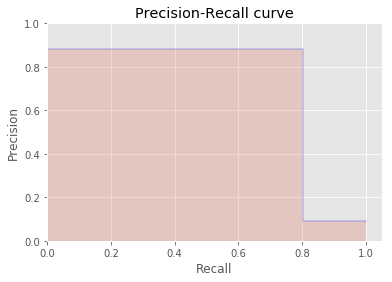

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, y_rf)

plt.step(recall, precision, alpha=0.2, where='post', color='b')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall curve')

**We can at least confirm we have avoided overfitting**

In [38]:
f1_score(y_test, y_rf)

0.84040416154468855

In [39]:
# running our estimator on new data
X_new = data2.drop(['is_churn', 'msno'], axis=1)
y_proba = rf_best.predict_proba(X_new)

# appending the probabilities to the test dataframe
rf_ans = data2[['msno', 'bd']]
rf_ans['is_churn'] = y_proba[:, 1]
rf_ans = rf_ans.drop(['bd'], axis=1)

C:\Users\Laolu\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
# the submission contains the probabilities of churn as opposed to whether churn or no churn
rf_ans.head(10)

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.011765
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.017647
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.005882
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.052941
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.182353
5,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0.002914
6,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,0.000082
7,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0.047059
8,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,0.023529
9,++1Wu2wKBA60W9F9sMh15RXmh1wN1fjoVGzNqvw/Gro=,0.000082


In [41]:
rf_ans.to_csv('submission1_v2.csv', index=False)

** This submission puts us at 145th out of 350 with a logloss of 0.15552. **